In [1]:
!nvidia-smi

Sat Aug  2 12:19:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:21:00.0 Off |                  Off |
| 30%   29C    P3             48W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -qq transformers accelerate mlx_lm ipywidgets 
!pip install -U -qq bitsandbytes

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import csv
import json

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import os

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append(".")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

from transformers import GenerationConfig

In [5]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        get_row_sizes,
                        reconstruct_grids,
                        generate_submission,
                        get_grid_shape)

In [6]:
train_data, test_data = load_data(data_path=Config.data_path)

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


# Try out LLM

In [7]:
base_prompt_path = "./src/base_prompt.txt"

model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False,
    target_platform=Config.target_platform,
    base_llm_name=Config.base_llm
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

[INFO] Quantized version loaded (8-bit: False, 4-bit: True)
[INFO] Successfully loaded base LLM (Qwen/Qwen2.5-14B-Instruct).


## Run generation

In [8]:
prompt = "How would you solve such puzzles to ensure the highest accuracy?"

inputs = model.prepare_model_inputs(prompt=prompt)

In [9]:
%%time

response = model.get_response(inputs=inputs, verbose=True)

[INFO] Prompting LLM...
[INFO] Done!
CPU times: user 31.4 s, sys: 264 ms, total: 31.7 s
Wall time: 31.6 s


In [10]:
print("".join(response))

Solving Abstraction and Reasoning Corpus (ARC) puzzles accurately involves a systematic approach that leverages pattern recognition, logical reasoning, and understanding of basic geometric transformations. Here’s a step-by-step guide to help you tackle these puzzles effectively:

### Step-by-Step Guide

#### 1. **Understand the Training Examples**
   - Carefully examine each provided training example to identify consistent patterns between the input and output grids.
   - Look for similarities in the arrangement of elements, colors, and shapes.

#### 2. **Identify Key Patterns**
   - **Shapes and Regions**: Determine if certain regions or shapes consistently transform into other regions or shapes. For instance, does a rectangle always turn into another rectangle of different size or orientation?
   - **Color Changes**: Note any consistent color transitions. Does a specific color always change to another specific color?

#### 3. **Analyze Transformation Rules**
   - **Repetition and Sym

## Solve Sample Task

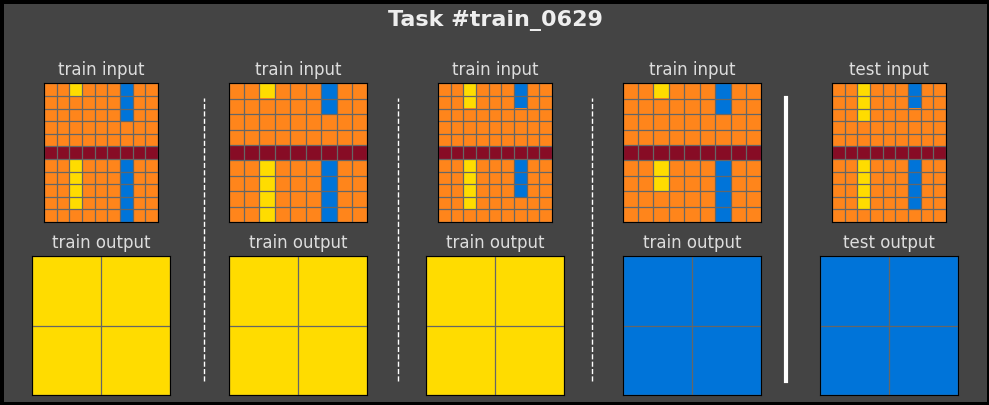

In [11]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [12]:
%%time 

expected_shape = get_grid_shape(test_output)

out = model.solve(
    task=task, 
    task_id=task_id,
    expected_rows=expected_shape[0],
    verbose=True
)

[INFO] All outputs have same shape
[INFO] Solving with LLM...
[INFO] In. shape: 		(11, 9)
[INFO] Expected Out. shape: 	(2, 2)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task #train_0629 	 Completion time: 1.2459 seconds
CPU times: user 984 ms, sys: 279 ms, total: 1.26 s
Wall time: 1.26 s


In [13]:
get_grid_shape(task["test"][0]["output"]) == get_grid_shape(out)

True

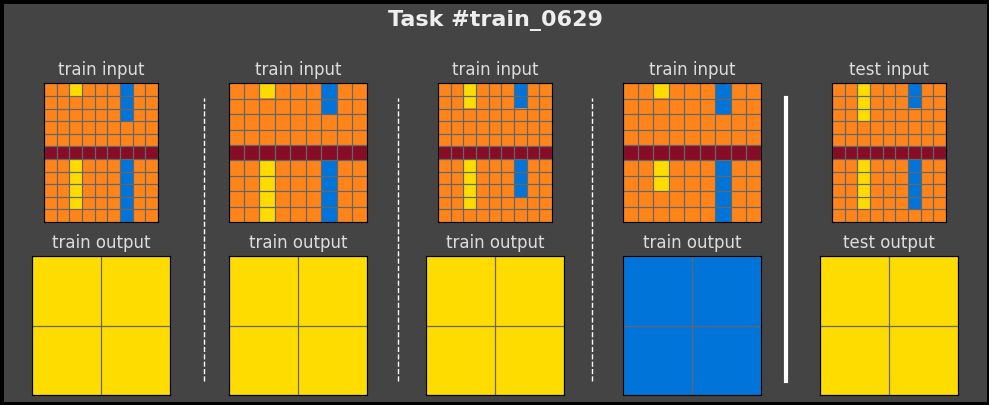

In [14]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [15]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 10

expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)  
    logger.info(f"{task_id=}")
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    pred = model.solve(
        task=task, 
        task_id=task_id,
        expected_rows=expected_shape[0] if expected_shape else None,
        verbose=True
    )

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0476'
[INFO] Input and output shapes are identical in all pairs
[INFO] Solving with LLM...
[INFO] In. shape: 		(20, 20)
[INFO] Expected Out. shape: 	(20, 20)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task #train_0476 	 Completion time: 52.0181 seconds

[INFO] task_id='train_0709'
[INFO] All outputs have same shape
[INFO] Solving with LLM...
[INFO] In. shape: 		(9, 9)
[INFO] Expected Out. shape: 	(3, 3)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task #train_0709 	 Completion time: 1.6271 seconds

[INFO] task_id='train_0008'
[INFO] Looking for constant scaling between input and output
[INFO] Inconsistency detected...exploring other options.
[INFO] Use test input shape with expected_rows override
[INFO] Solving with LLM...
[INFO] In. shape: 		(15, 12)
[INFO] Expected Out. shape: 	(5, 12)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task #train_0008 	 Completion time: 7.1967 seconds

[INFO] task_id='train_0028'
[INFO] Input and output shapes are identical in all pai

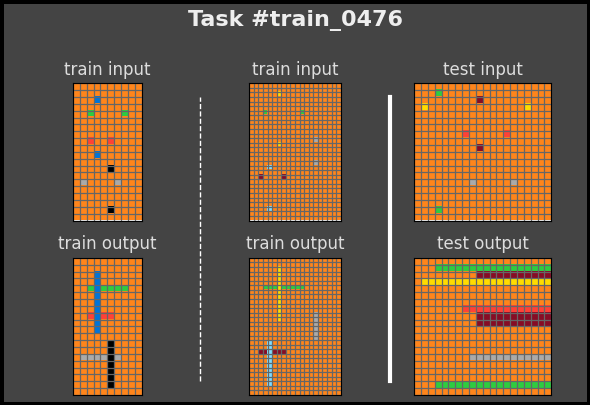

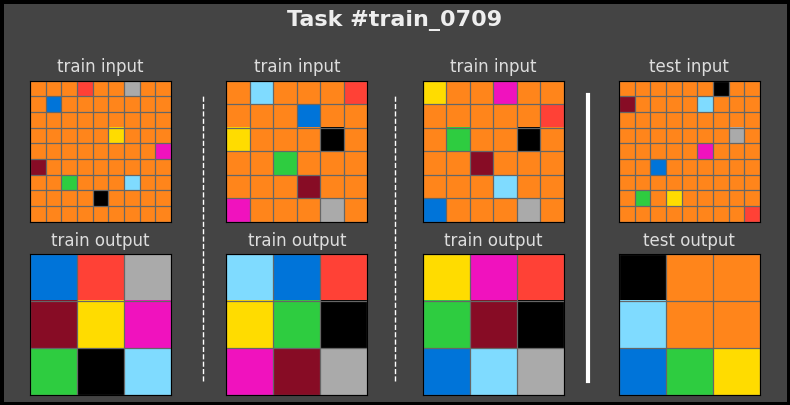

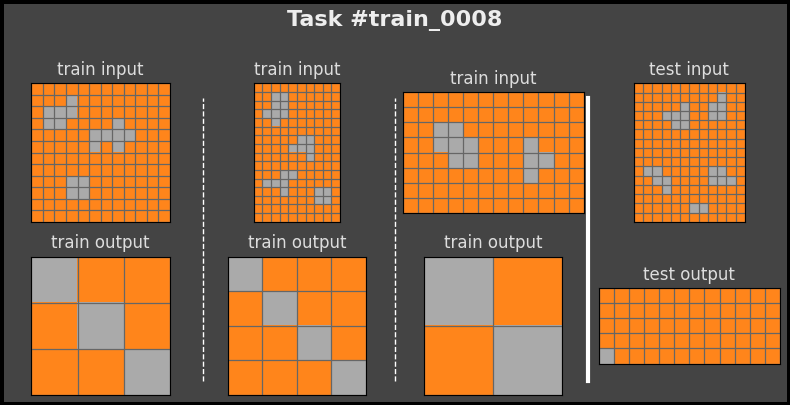

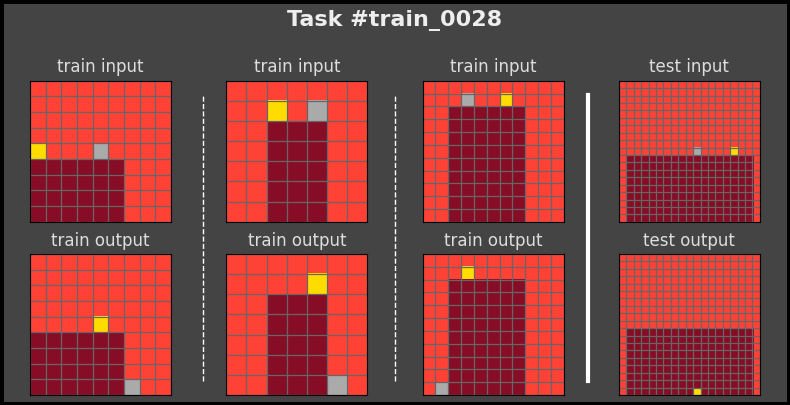

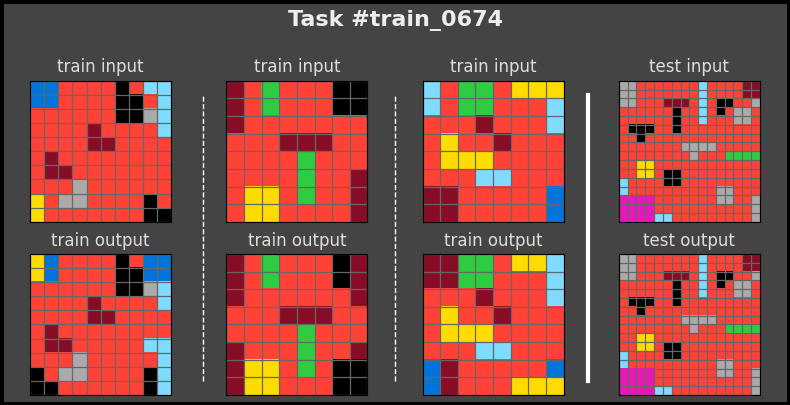

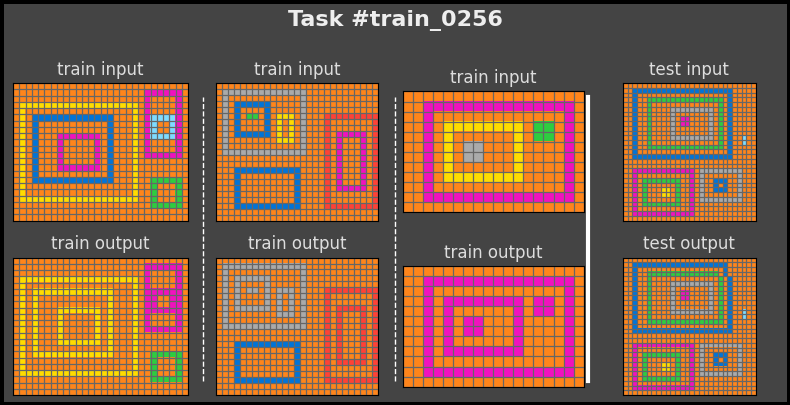

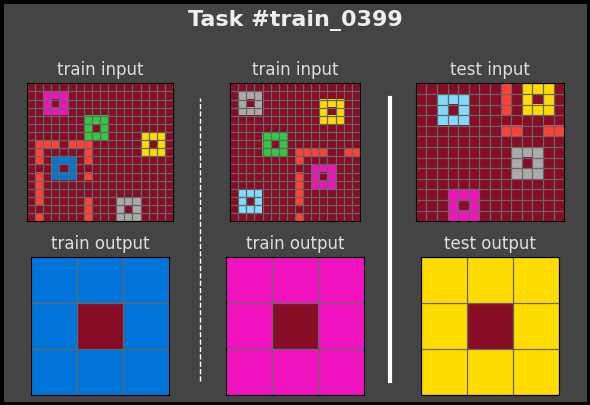

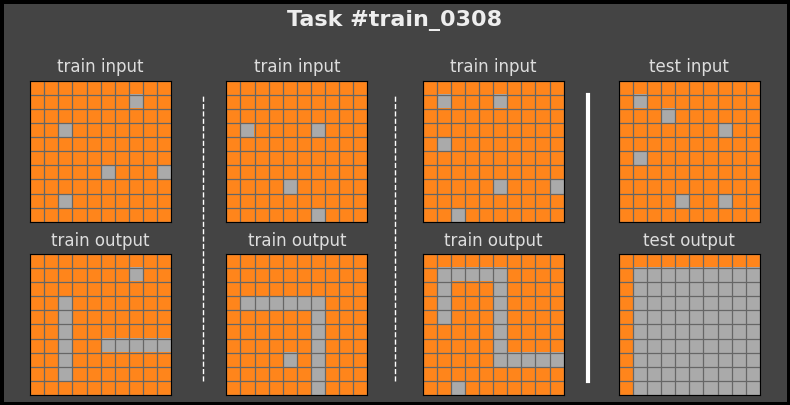

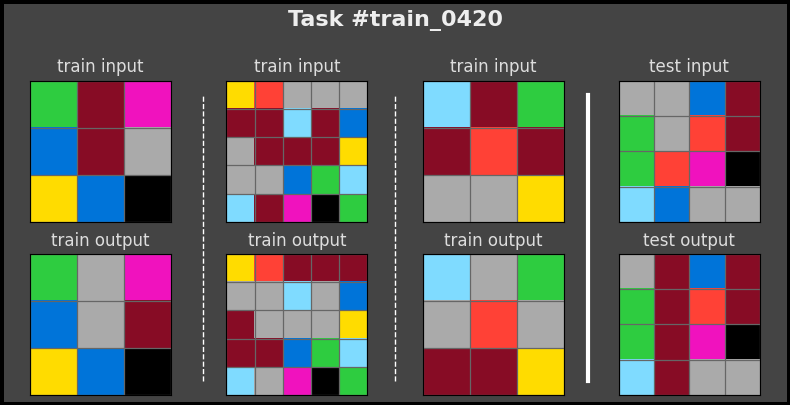

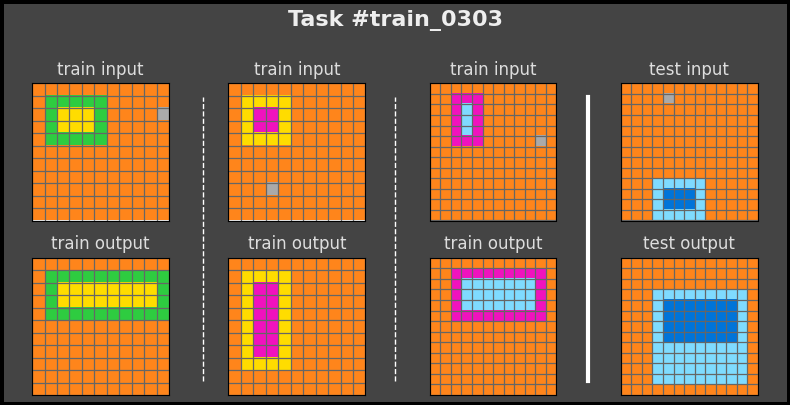

In [16]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [25]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join(Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [29]:
test_out_rows = get_row_sizes(ss)
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


In [28]:
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=True)
test_out_rows_sorted

,ID_,n_rows
135,test_0135,1
169,test_0169,1
143,test_0143,2
54,test_0054,2
123,test_0123,2
...,...,...
4,test_0004,30
74,test_0074,30
161,test_0161,30
36,test_0036,30


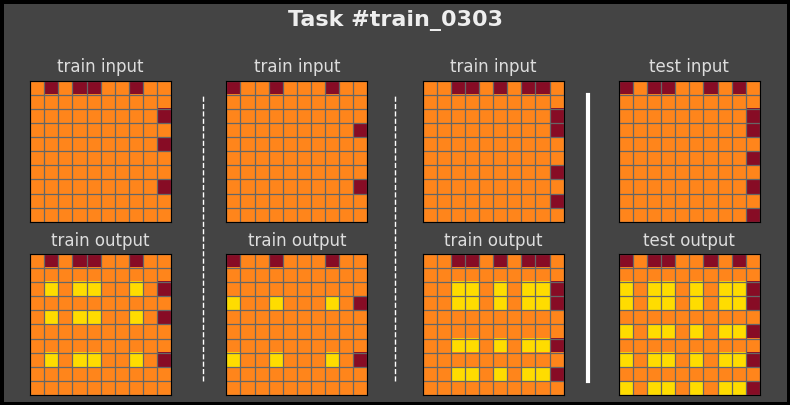

In [30]:
test_case = "test_0002"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == test_case, "n_rows"].item()
task = test_data[test_case]

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [31]:
%%time 

pred = model.solve(
    task=task, 
    task_id=task_id,
    verbose=True
) 

[INFO] Input and output shapes are identical in all pairs
[INFO] Solving with LLM...
[INFO] In. shape: 		(10, 10)
[INFO] Expected Out. shape: 	(10, 10)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task #train_0303 	 Completion time: 13.2784 seconds
CPU times: user 12.9 s, sys: 430 ms, total: 13.3 s
Wall time: 13.3 s


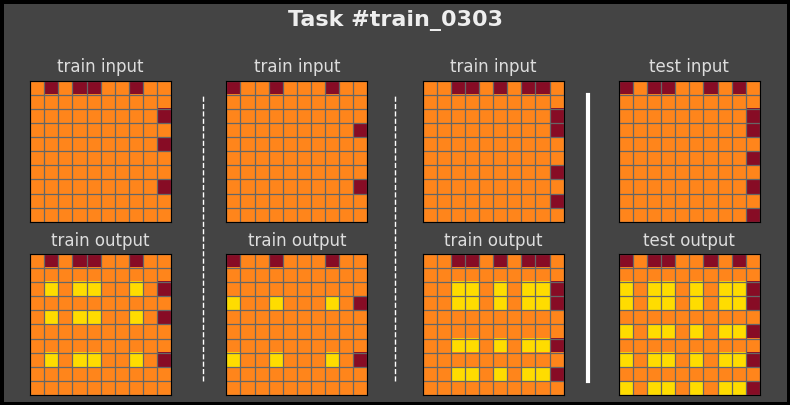

In [32]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

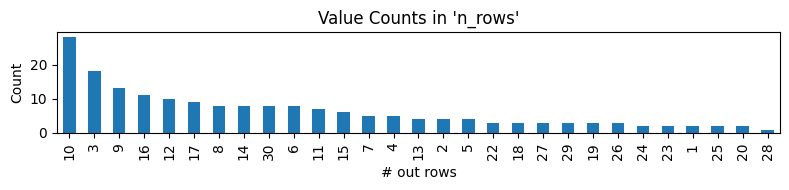

In [33]:
value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 2))
plt.xlabel("# out rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [34]:
%%time

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):    
    task_id = row.ID_
    task = test_data[task_id]
    train = task["train"]
    test = task["test"][0]

    pred = model.solve(
        task=task, 
        verbose=False,
        task_id=task_id,
        expected_rows=row.n_rows,
    )  
    test_preds.append(pred)


  0%|          | 0/185 [00:00<?, ?it/s]

[INFO] Task #test_0135 	 Completion time: 0.6797 seconds
[INFO] Task #test_0169 	 Completion time: 2.2335 seconds
[INFO] Task #test_0143 	 Completion time: 1.5470 seconds
[INFO] Task #test_0054 	 Completion time: 0.9315 seconds
[INFO] Task #test_0123 	 Completion time: 0.8783 seconds
[INFO] Task #test_0108 	 Completion time: 1.7934 seconds
[INFO] Task #test_0179 	 Completion time: 3.9261 seconds
[INFO] Task #test_0032 	 Completion time: 0.9924 seconds
[INFO] Task #test_0042 	 Completion time: 3.8034 seconds
[INFO] Task #test_0057 	 Completion time: 1.8077 seconds
[INFO] Task #test_0061 	 Completion time: 2.5307 seconds
[INFO] Task #test_0044 	 Completion time: 1.4415 seconds
[INFO] Task #test_0124 	 Completion time: 1.6164 seconds
[INFO] Task #test_0118 	 Completion time: 6.8867 seconds
[INFO] Task #test_0066 	 Completion time: 1.4301 seconds
[INFO] Task #test_0068 	 Completion time: 2.9783 seconds
[INFO] Task #test_0060 	 Completion time: 1.4422 seconds
[INFO] Task #test_0017 	 Comple

In [35]:
len(test_preds)

185

# Submission

In [37]:
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}.csv"
out_path = osp.join(Config.submission_path, sub_filename)

generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows_sorted, 
    output_path=out_path
)

[INFO] Submission saved to ./submissions/2025-08-02_14-40-submission-arc-solver-Qwen2.5-14B-Instruct-llm-fs.csv


In [38]:
submision = pd.read_csv(out_path)
submision

,ID,row
0,test_0000_1,7777777777
1,test_0000_2,7667776667
2,test_0000_3,7767777767
3,test_0000_4,7677777677
4,test_0000_5,7666776666
...,...,...
2298,test_0184_6,7733333777777777777
2299,test_0184_7,7777777777777777777
2300,test_0184_8,7777777777777777777
2301,test_0184_9,7777777777777777777


In [39]:
submision.shape == ss.shape

True

In [40]:
100*sum(submision.ID == ss.ID)/ ss.shape[0]

100.0

In [44]:
predictions = reconstruct_grids(submision)
len(predictions)

185

test_0017


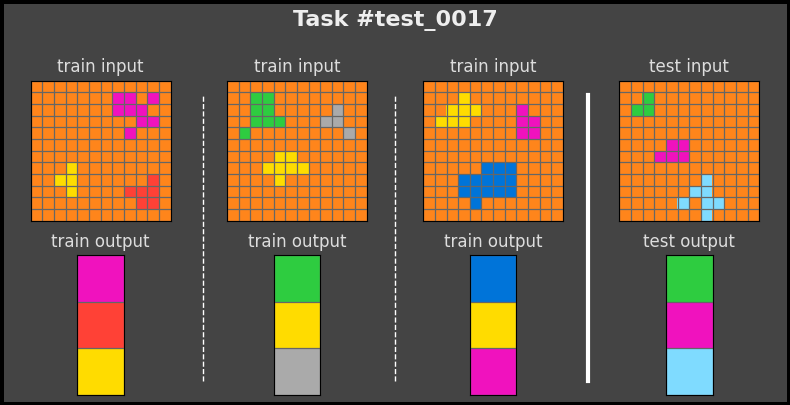

test_0142


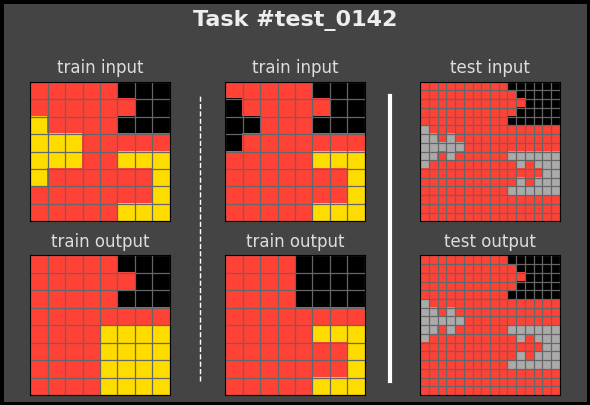

test_0077


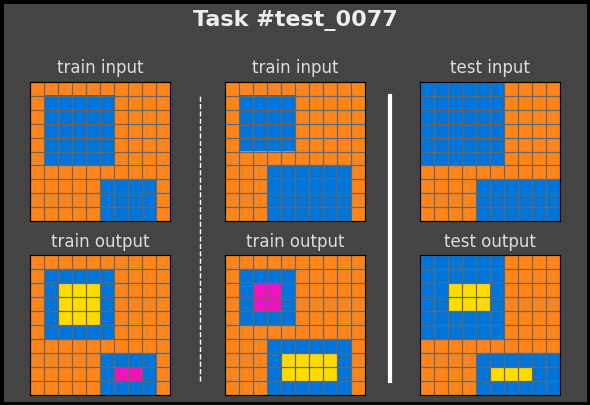

test_0062


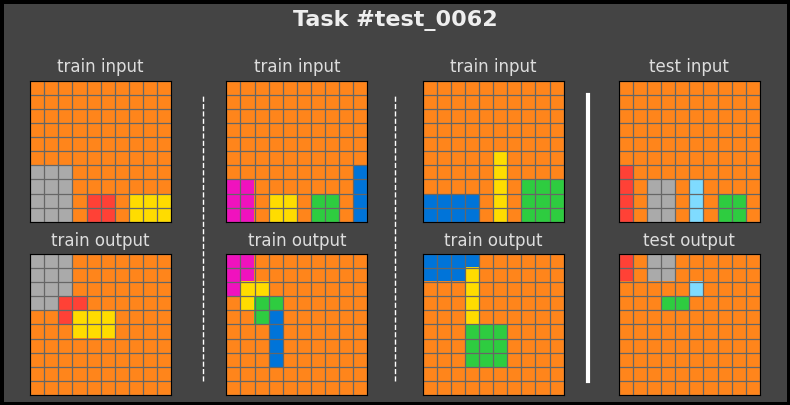

test_0028


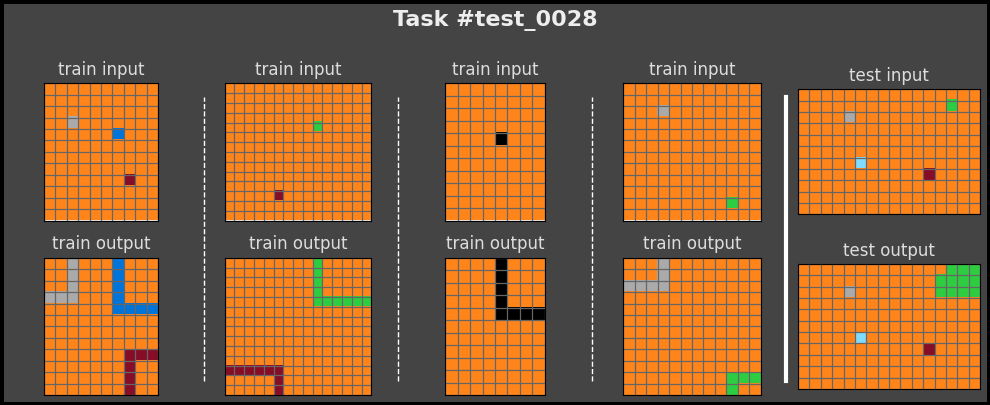

test_0068


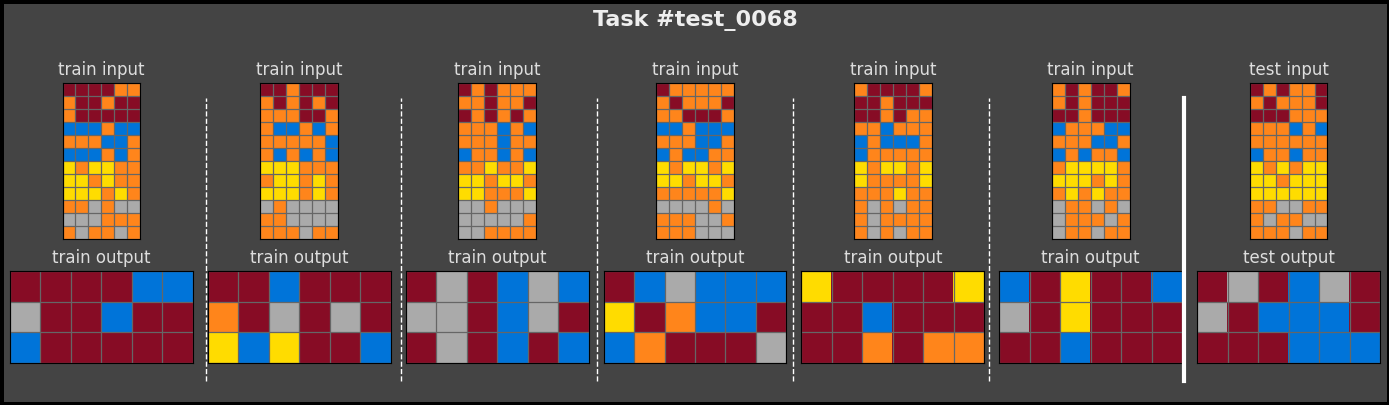

test_0012


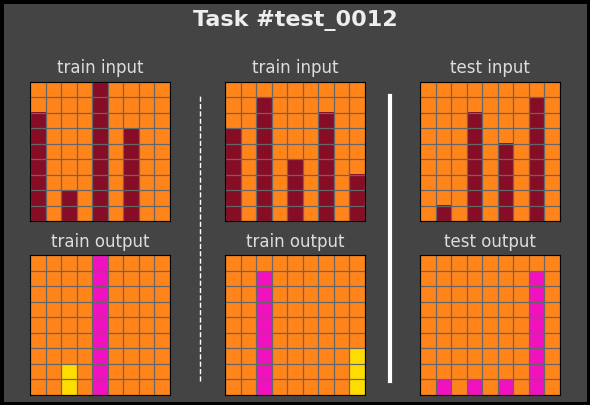

test_0156


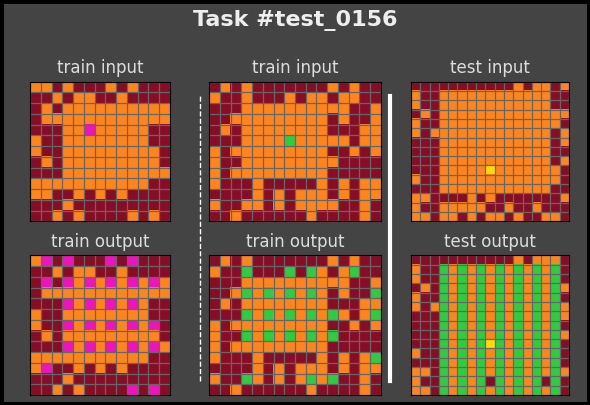

test_0020


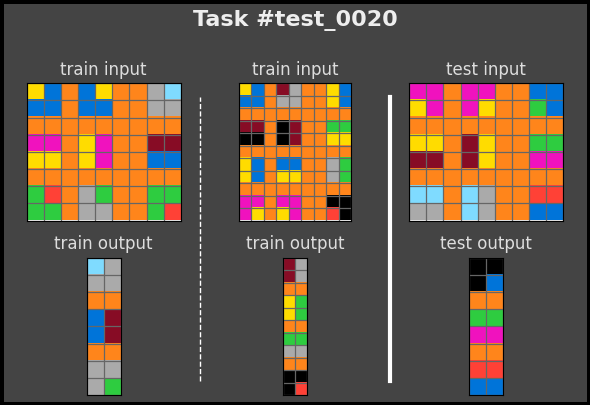

test_0112


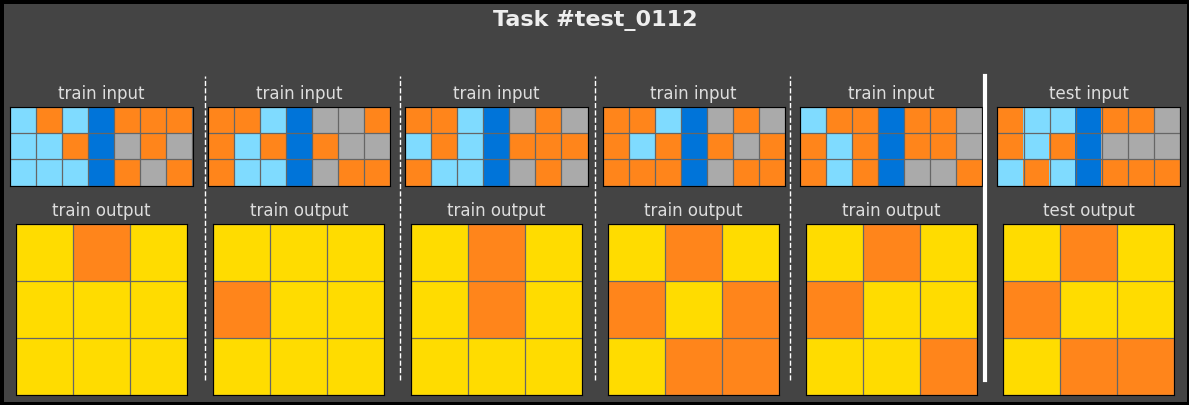

test_0070


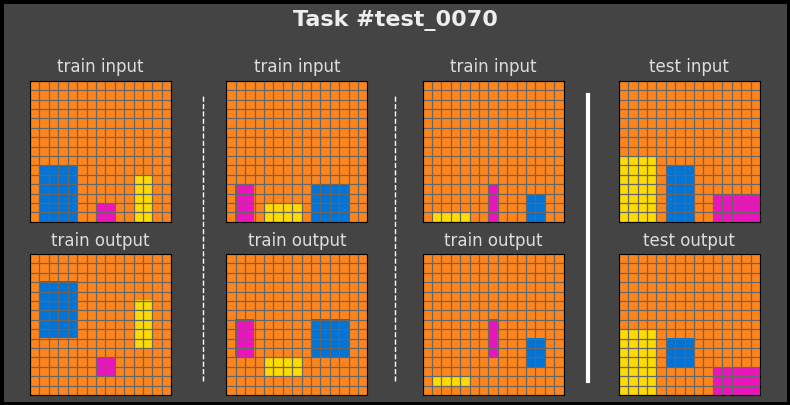

test_0183


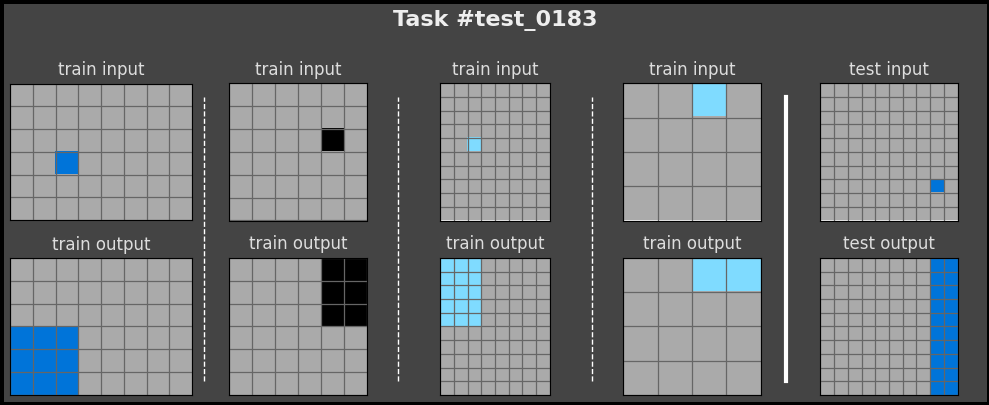

test_0050


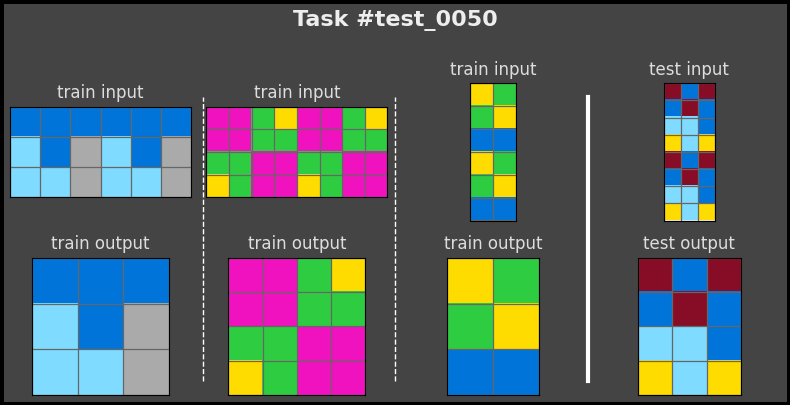

test_0009


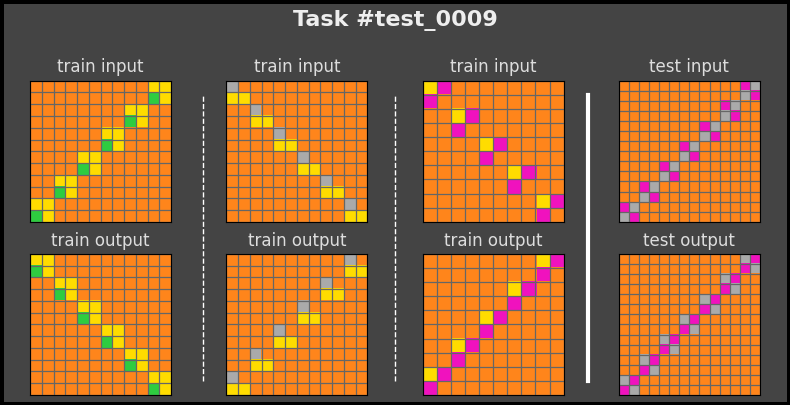

test_0158


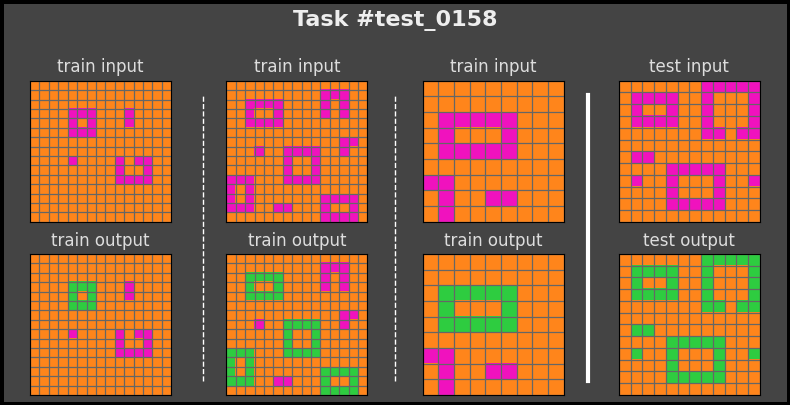

test_0179


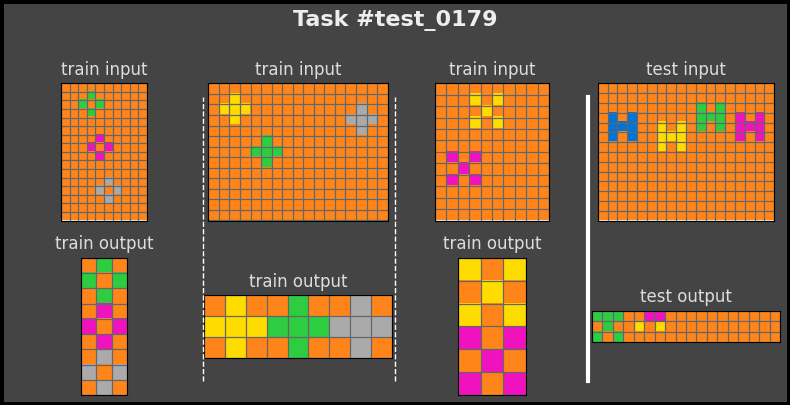

test_0141


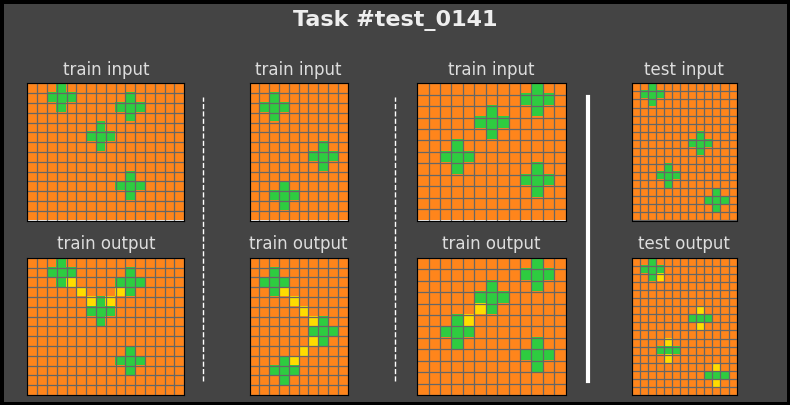

test_0003


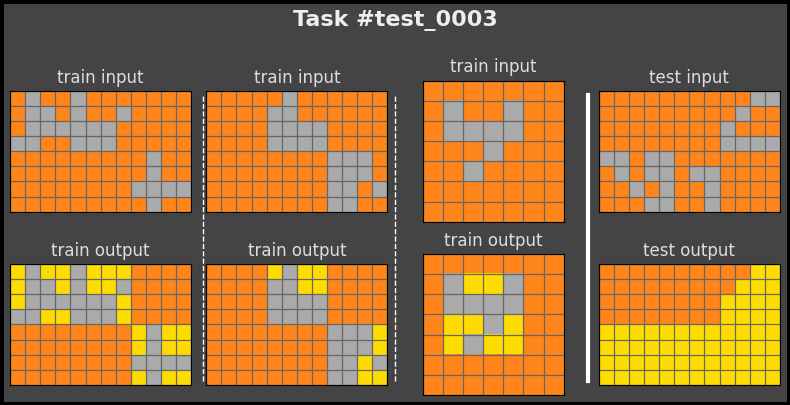

test_0001


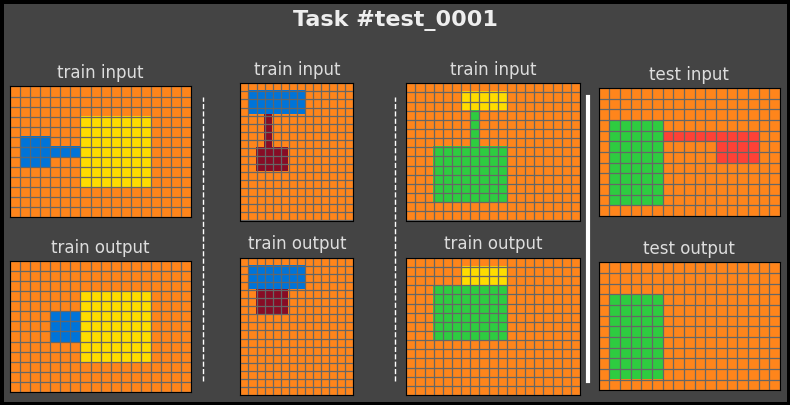

test_0114


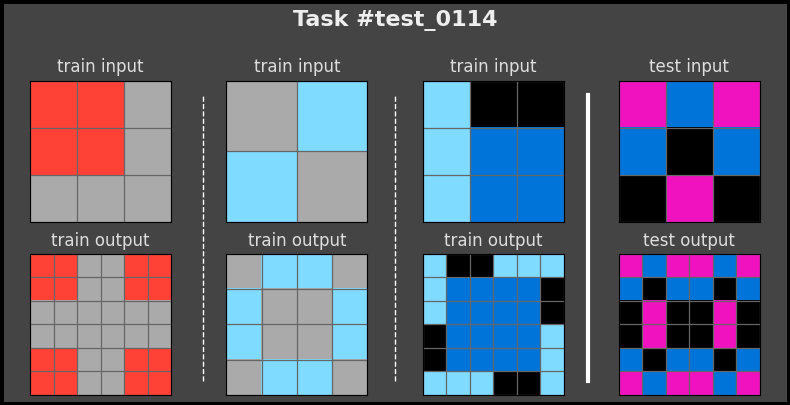

In [54]:
for i in range(20):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    print(task_id)
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)